In [2]:
from __future__ import division, print_function
# ingnore warnings Anaconda
import warnings
warnings.filterwarnings('ignore')
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, classification_report, confusion_matrix
from datetime import datetime
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.models import Sequential
from keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from keras.regularizers import l1_l2
from tensorflow.keras.layers import BatchNormalization
import tensorflow as tf

import xgboost as xgb

# if we do not want to install CUDA
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [3]:
train_df = pd.read_csv(os.path.join('./train_merge', 'train_data.csv'))
test_df = pd.read_csv(os.path.join('./test_merge', 'test_data.csv'))  

train_df_without_names = pd.concat([train_df.iloc[:, 4:20], train_df.iloc[:, 21:]], axis=1)
test_df_without_names = pd.concat([test_df.iloc[:, 4:20], test_df.iloc[:, 21:]], axis=1)

train_df_with_important_features = train_df_without_names[['away_total_yards', 'home_total_yards', 'home_rush_yards', 'away_rush_yards', 'home_firstdowns', 'away_competions', 'home_competions', 'away_firstdowns', 'away_rush', 'home_rush', 'away_points', 'away_pass_yards', 'home_pass_yards', 'away_pass_att', 'home_pass_att', 'away_penality_yards', 'home_penality_yards', 'home_points']]
y = train_df_without_names['Home_Win']
test_df_with_important_features = test_df_without_names[['away_total_yards', 'home_total_yards', 'home_rush_yards', 'away_rush_yards', 'home_firstdowns', 'away_competions', 'home_competions', 'away_firstdowns', 'away_rush', 'home_rush', 'away_points', 'away_pass_yards', 'home_pass_yards', 'away_pass_att', 'home_pass_att', 'away_penality_yards', 'home_penality_yards', 'home_points']]
train_test_with_important_features = pd.concat([train_df_with_important_features, test_df_with_important_features])

In [4]:
X_train_with_important_features = train_test_with_important_features[:train_df_with_important_features.shape[0]]
# X_test_with_important_features = train_test_with_important_features[train_df_with_important_features.shape[0]:]

train_share_with_important_features = int(.7 * X_train_with_important_features.shape[0])
X_train, y_train = X_train_with_important_features.iloc[:train_share_with_important_features, :].values, y[:train_share_with_important_features].values
X_test, y_test = X_train_with_important_features.iloc[train_share_with_important_features:, :].values, y[train_share_with_important_features:].values

X_train=np.asarray(X_train).astype(np.int)
X_test=np.asarray(X_test).astype(np.int)

In [5]:
#our NN has 2 outputs (True, False) - 2 categories
y_train_cat = to_categorical(y_train, 2)
y_test_cat = to_categorical(y_test, 2)
n_cols = X_train.shape[1]

model = Sequential()
model.add(Dense(40, activation='relu', input_shape=(n_cols, )))
model.add(BatchNormalization())
model.add(Dense(30, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
model.add(BatchNormalization())
model.add(Dense(20, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
model.add(BatchNormalization())
model.add(Dense(10, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
model.add(BatchNormalization())
model.add(Dense(2, activation='softmax'))

In [6]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [7]:
EPOCHS = 34
H = model.fit(X_train, y_train_cat, epochs=EPOCHS, batch_size=10, validation_split=0.2)

Epoch 1/34
227/227 [==============================] - 1s 1ms/step - loss: 3.3352 - accuracy: 0.7321 - val_loss: 2.2630 - val_accuracy: 0.8534
Epoch 2/34
227/227 [==============================] - 0s 878us/step - loss: 1.6528 - accuracy: 0.8227 - val_loss: 1.1718 - val_accuracy: 0.9152
Epoch 3/34
227/227 [==============================] - 0s 885us/step - loss: 0.9314 - accuracy: 0.8568 - val_loss: 0.7625 - val_accuracy: 0.8339
Epoch 4/34
227/227 [==============================] - 0s 860us/step - loss: 0.6220 - accuracy: 0.8802 - val_loss: 0.4578 - val_accuracy: 0.9258
Epoch 5/34
227/227 [==============================] - 0s 870us/step - loss: 0.4542 - accuracy: 0.8868 - val_loss: 0.3246 - val_accuracy: 0.9382
Epoch 6/34
227/227 [==============================] - 0s 869us/step - loss: 0.3588 - accuracy: 0.8988 - val_loss: 0.2544 - val_accuracy: 0.9452
Epoch 7/34
227/227 [==============================] - 0s 876us/step - loss: 0.3074 - accuracy: 0.9098 - val_loss: 0.5793 - val_accuracy: 0

In [8]:
model.evaluate(X_test, y_test_cat)

38/38 [==============================] - 0s 536us/step - loss: 0.2395 - accuracy: 0.9200


[0.2394820898771286, 0.919966995716095]

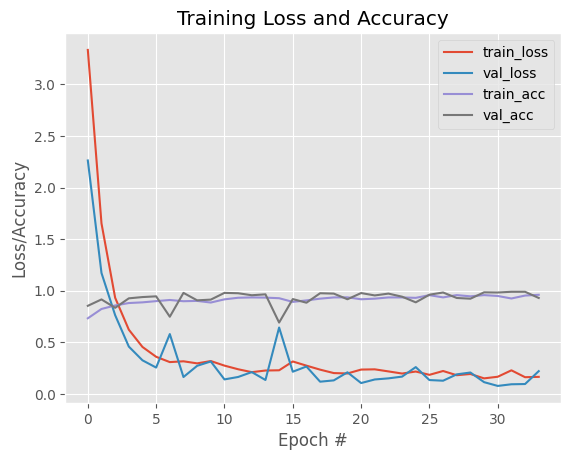

In [9]:
# build accuracy and loss plot
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

In [10]:
model.save('keras.model')

INFO:tensorflow:Assets written to: keras.model/assets


INFO:tensorflow:Assets written to: keras.model/assets


In [11]:
new_model = tf.keras.models.load_model('keras.model')

In [12]:
#During game (for example) collect and insert game parametes, that already have appeared
away_total_yards = 200
home_total_yards = 100
home_rush_yards = 10
away_rush_yards = 11
home_firstdowns = 8
away_competions = 9
home_competions = 8
away_firstdowns = 10
away_rush = 20
home_rush = 10
away_points = 0
away_pass_yards = 80
home_pass_yards = 100
away_pass_att = 15
home_pass_att = 13
away_penality_yards = 4
home_penality_yards = 2
home_points = 0
real_game_list = [away_total_yards, home_total_yards, home_rush_yards, away_rush_yards, home_firstdowns, away_competions, home_competions, away_firstdowns, away_rush, home_rush, away_points, away_pass_yards, home_pass_yards, away_pass_att, home_pass_att, away_penality_yards, home_penality_yards, home_points]

In [13]:
predictions = new_model.predict([X_test])

38/38 [==============================] - 0s 486us/step


In [14]:
real_predictions = new_model.predict([real_game_list])

1/1 [==============================] - 0s 62ms/step


In [15]:
predictions = predictions[:, :1]
predictions_list = [[j * 100 for j in i]for i in predictions]

In [16]:
#if value closer to 0, then HOME_WIN - True
#elif value closer to 100, then HOME_WIN - False
real_predictions = real_predictions[:, :1]
real_predictions_list = [[j * 100 for j in i]for i in real_predictions]
print(real_predictions_list)

[[97.05461263656616]]


In [17]:
y_test_list = [i for i in y_test]

In [18]:
print(list(zip(predictions_list, y_test_list)))

[([0.0037493296986212954], True), ([25.99148452281952], False), ([0.00044803514356317464], True), ([4.041705636836923e-07], True), ([42.19044744968414], False), ([0.1568516017869115], True), ([4.4975485652685165], True), ([97.89721965789795], False), ([0.0001346225189990946], True), ([96.68679237365723], False), ([4.6890327176640767e-07], True), ([9.148063782049576e-05], True), ([95.8742082118988], False), ([1.2766939505581831e-06], True), ([4.109684005379677], True), ([85.08397936820984], False), ([0.0021822737835464068], True), ([10.778457671403885], True), ([0.00012593527571880259], True), ([63.48600387573242], False), ([17.510823905467987], True), ([0.42012562043964863], True), ([0.0001739360072861018], True), ([51.59485340118408], False), ([5.172924488761055e-05], True), ([19.075189530849457], True), ([97.2459614276886], False), ([0.00292273562081391], True), ([8.649986966702272e-05], True), ([0.026222359156236053], True), ([0.020923650299664587], True), ([15.586358308792114], Fal